# Important note

1. This notebook is built upon this quickstarter by https://www.kaggle.com/code/ambrosm/msci-multiome-quickstart

2. It reads the Multime traning data in sparse mode,from this dataset: https://www.kaggle.com/datasets/sbunzini/open-problems-msci-multiome-sparse-matrices

3. During CV this NB reads the whole training dataset,in four chunks. It takes 33 minutes to complete.

4. It uses truncatedSVD for reducing the number of features, to 512.

5. The model is Ridge. I tried LinearRegression and KNN  (very fast) and DecisionTrees, LinearSVD (dual=False),LGBM and CatBoost (excruciatingly slow).

6. The CV is about 0.658, which is not an improvement. 

I hope this helps.

# Multiome Quickstart

This notebook shows how to cross-validate a baseline model and create a submission for the Multiome part of the *Multimodal Single-Cell Integration* competition without running out of memory.

It does not show the EDA - see the separate notebook [MSCI EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/ambrosm/msci-eda-which-makes-sense).

The baseline model for the other part of the competition (CITEseq) is [here](https://www.kaggle.com/ambrosm/msci-citeseq-quickstart).

In [1]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
import tensorflow as tf
import scipy.sparse as sps
from scipy.sparse.linalg import lsqr
import math

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Dropout,Dense, Input, Concatenate, Conv1D, Flatten, MaxPool1D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.decomposition import TruncatedSVD
#from sklearn.preprocessing import StandardScaler, scale
#from sklearn.decomposition import PCA
#from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, HuberRegressor
from sklearn.metrics import mean_squared_error

#import lightgbm as lgb
#import catboost as cb
#from catboost import CatBoost,CatBoostRegressor, Pool
#from sklearn.multioutput import MultiOutputRegressor

DATA_DIR = "./data/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

# The scoring function

It is a slight modification of the original scoring function. No averages.

In [2]:
def correlation_score(y_true, y_pred):
    """Scores the predictions according to the competition rules. 
    
    It is assumed that the predictions are not constant.
    
    Returns the average of each sample's Pearson correlation coefficient"""
    if type(y_true) == pd.DataFrame: y_true = y_true.values
    if type(y_pred) == pd.DataFrame: y_pred = y_pred.values
    if y_true.shape != y_pred.shape: raise ValueError("Shapes are different.")
    corrsum = 0
    for i in range(len(y_true)):
        corrsum += np.corrcoef(y_true[i], y_pred[i])[1, 0]
   
    return corrsum, len(y_true)
    #return corrsum / len(y_true)

    
def negative_correlation_loss(y_true, y_pred):
    """Negative correlation loss function for Keras
    
    NO Precondition:
    y_true.mean(axis=1) == 0
    y_true.std(axis=1) == 1
    
    Returns:
    -1 = perfect positive correlation
    1 = totally negative correlation
    """

    my = K.mean(tf.convert_to_tensor(y_pred), axis=1)
    my_true = K.mean(tf.convert_to_tensor(y_true), axis=1)
    my = tf.tile(tf.expand_dims(my, axis=1), (1, K.shape(y_pred)[1]))
    my_true = tf.tile(tf.expand_dims(my_true, axis=1), (1, K.shape(y_true)[1]))
    ym = y_pred - my
    ym_true = y_true - my_true
    r_num = K.sum(tf.multiply(ym_true, ym), axis=1)
    r_den = tf.sqrt(K.sum(K.square(ym), axis=1) * K.sum(K.square(ym_true), axis=1))
    r = tf.reduce_mean(r_num / r_den)
    return - r


# Preprocessing and cross-validation

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
cite_train_x_df = pd.read_hdf(FP_CITE_TRAIN_INPUTS)

In [5]:
cite_train_y_raw = pd.read_hdf(FP_CITE_TRAIN_TARGETS).values

In [6]:
cell_df = pd.read_csv("df_cell.csv")
cell_df = cell_df[['cell_id','day','donor_index']]
cell_df.astype({'day':'float32','donor_index':'float32'})

,cell_id,day,donor_index
0,c2150f55becb,2.0,0.0
1,65b7edf8a4da,2.0,0.0
2,526647a698f8,2.0,0.0
3,ab8f207a3dec,2.0,0.0
4,08df3dcce25c,2.0,0.0
...,...,...,...
281523,96a60b026659,10.0,3.0
281524,d493e546991e,10.0,3.0
281525,05666c99aa48,10.0,3.0
281526,121f946642b5,10.0,3.0


In [7]:
cite_train_x_df = cite_train_x_df.merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')

In [8]:
cite_train_x_raw = cite_train_x_df.values

In [9]:
cite_train_y_raw.shape

(70988, 140)

In [10]:
cite_train_x_raw.shape

(70988, 22052)

In [11]:
del cite_train_x_df
gc.collect()

0

In [12]:
def my_model(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [13]:
def my_model_2(input_size = 200, output_size = 200, middle_size = 100, layer_num = 4, init_dropout = 0.2, layer_dropout=0.2, activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, ))
    vip_inputs = tf.slice(inputs, [0, input_size - 2], [-1,2])
    
    inputs_dropout = Dropout(init_dropout)(inputs)
    
    
    layers = [inputs_dropout]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))
    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [14]:
def my_model_cnn(input_size = 200, 
                 output_size = 200, 
                 middle_size = 100, 
                 layer_num = 4, 
                 feature_num = 32,
                 feature_shape = 3,
                 layer_num_cnn=4, 
                 init_dropout = 0.2, 
                 cnn_dropout=0.2,
                 layer_dropout=0.2, 
                 activation = 'swish'):
    """Sequential neural network
    
    Returns a compiled instance of tensorflow.keras.models.Model.
    """

    inputs = Input(shape=(input_size, 1))
    vip_inputs = (tf.slice( Flatten()(inputs), [0, input_size - 2], [-1,2]))

    inputs_dropout = Dropout(init_dropout)(inputs)
    cnn_layers = [inputs_dropout]

    for ci in range(layer_num_cnn):
        cnn_layers.append(Dropout(cnn_dropout)(MaxPool1D(feature_shape//2 + 1)(Conv1D(feature_num * (2 ** ci), kernel_size=(feature_shape,))(cnn_layers[ci]))))
    
    layers = [Flatten()(cnn_layers[-1])]
    for i in range(layer_num - 1):
        layers.append(Concatenate()([Dropout(layer_dropout-0.1*i)(Dense(middle_size-2, activation=activation)(layers[i])), vip_inputs]))

    last_layer = Dense(output_size)(layers[-1])

    regressor = Model(inputs, last_layer)
    
    return regressor

In [15]:
lam = 0.00

class CorrelationLoss_new(tf.keras.losses.Loss):
    
    def call(self, y_true, y_pred):
        return negative_correlation_loss(y_true, y_pred) + lam * tf.keras.losses.MeanSquaredError()(y_true,y_pred)

In [16]:
class MultiomeSequence(tf.keras.utils.Sequence):

    def __init__(self, x_set, y_set, batch_size=64):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

In [17]:
class MultiomeSequence_test(tf.keras.utils.Sequence):

    def __init__(self, x_set, batch_size=64):
        self.x= x_set
        self.batch_size = batch_size

    def __len__(self):
        return self.x.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Return the idx-th batch
        """

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x
        

In [18]:
cite_train_x_raw_new = np.expand_dims(cite_train_x_raw, axis=2)

In [19]:
cite_train_x_raw_new.shape

(70988, 22052, 1)

In [21]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_cnn(cite_train_x_raw_new.shape[1], 
                     cite_train_y_raw.shape[1], 
                     middle_size=512, 
                     layer_num=4, 
                     feature_shape=9, 
                     feature_num=32, 
                     layer_num_cnn=4,
                     init_dropout=0.2, 
                     layer_dropout=0.7, 
                     activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 22052, 1)]   0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 22052, 1)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 22044, 32)    320         dropout[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 4408, 32)     0           conv1d[0][0]                     
______________________________________________________________________________________________

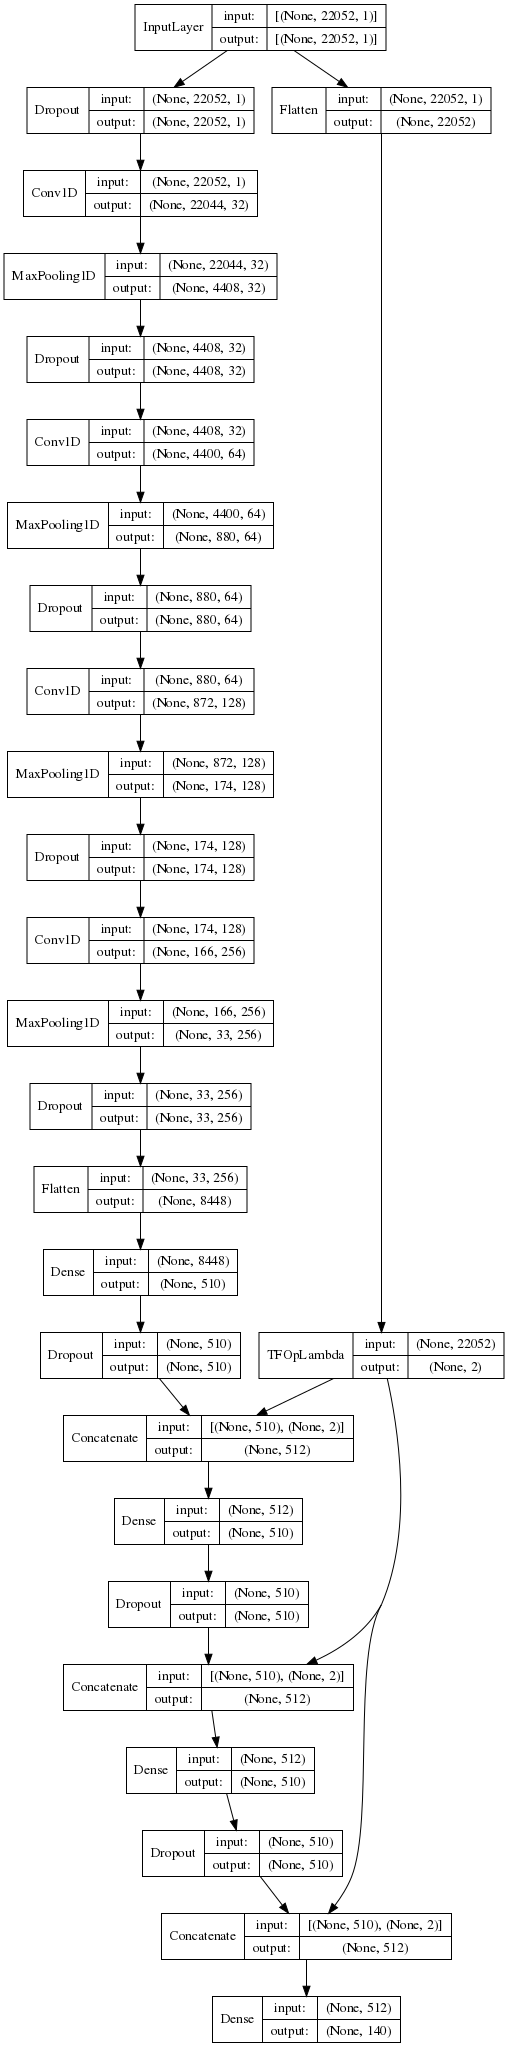

In [22]:
display(plot_model(model, show_layer_names=False, show_shapes=True, dpi=72))

In [22]:
# checkpoint_filepath = './cite_v32/checkpoint{epoch:02d}'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='loss', save_freq=15*100, save_best_only=False, mode='auto')

In [23]:
kf = KFold(n_splits = 8, shuffle = True, random_state=123)
score_list = []
b_size = 512
idx_tr, idx_va = next(kf.split(cite_train_x_raw))

In [24]:
training_generator = MultiomeSequence(cite_train_x_raw_new[idx_tr], cite_train_y_raw[idx_tr], batch_size=b_size)
validation_generator = MultiomeSequence(cite_train_x_raw_new[idx_va], cite_train_y_raw[idx_va], batch_size=b_size)
# retraining_generator = MultiomeSequence(cite_train_x_raw_new, cite_train_y_raw, batch_size=b_size)

In [25]:
# model.load_weights("./model/cite_v35")

In [25]:
epoc=300
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/300
121/121 [==============================] - 35s 266ms/step - loss: -0.7573
Epoch 2/300
121/121 [==============================] - 32s 263ms/step - loss: -0.7981
Epoch 3/300
121/121 [==============================] - 32s 264ms/step - loss: -0.8015
Epoch 4/300
121/121 [==============================] - 32s 260ms/step - loss: -0.8026
Epoch 5/300
121/121 [==============================] - 33s 274ms/step - loss: -0.8037 - val_loss: -0.8071
Epoch 6/300
121/121 [==============================] - 31s 260ms/step - loss: -0.8039
Epoch 7/300
121/121 [==============================] - 32s 260ms/step - loss: -0.8042
Epoch 8/300
121/121 [==============================] - 32s 260ms/step - loss: -0.8045
Epoch 9/300
121/121 [==============================] - 32s 262ms/step - loss: -0.8046
Epoch 10/300
121/121 [==============================] - 33s 274ms/step - loss: -0.8046 - val_loss: -0.8080
Epoch 11/300
121/121 [==============================] - 32s 260ms/step - loss: -0.8047
Epoch 12/300

121/121 [==============================] - 31s 259ms/step - loss: -0.8881
Epoch 92/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8882
Epoch 93/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8880
Epoch 94/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8882
Epoch 95/300
121/121 [==============================] - 33s 272ms/step - loss: -0.8884 - val_loss: -0.8946
Epoch 96/300
121/121 [==============================] - 32s 262ms/step - loss: -0.8884
Epoch 97/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8887
Epoch 98/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8886
Epoch 99/300
121/121 [==============================] - 32s 263ms/step - loss: -0.8886
Epoch 100/300
121/121 [==============================] - 34s 277ms/step - loss: -0.8885 - val_loss: -0.8947
Epoch 101/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8881
Epoch 102/300


121/121 [==============================] - 33s 272ms/step - loss: -0.8914 - val_loss: -0.8972
Epoch 181/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8917
Epoch 182/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8918
Epoch 183/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8918
Epoch 184/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8918
Epoch 185/300
121/121 [==============================] - 33s 272ms/step - loss: -0.8917 - val_loss: -0.8976
Epoch 186/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8918
Epoch 187/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8918
Epoch 188/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8919
Epoch 189/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8920
Epoch 190/300
121/121 [==============================] - 33s 272ms/step - loss: -0.8919 - val_

121/121 [==============================] - 31s 259ms/step - loss: -0.8933
Epoch 270/300
121/121 [==============================] - 33s 272ms/step - loss: -0.8932 - val_loss: -0.8984
Epoch 271/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8933
Epoch 272/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8934
Epoch 273/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8926
Epoch 274/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8930
Epoch 275/300
121/121 [==============================] - 33s 272ms/step - loss: -0.8932 - val_loss: -0.8987
Epoch 276/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8932
Epoch 277/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8932
Epoch 278/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8933
Epoch 279/300
121/121 [==============================] - 31s 259ms/step - loss: -0.8933
Epoch 

In [ ]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [27]:
model.save("./model/cite_v37_cont")

INFO:tensorflow:Assets written to: ./model/cite_v37_cont/assets


In [28]:
epoc=1000
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8934
Epoch 2/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8937
Epoch 3/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8937
Epoch 4/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8938
Epoch 5/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8937 - val_loss: -0.8986
Epoch 6/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8935
Epoch 7/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8927
Epoch 8/1000
121/121 [==============================] - 31s 260ms/step - loss: -0.8933
Epoch 9/1000
121/121 [==============================] - 31s 260ms/step - loss: -0.8935
Epoch 10/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8935 - val_loss: -0.8988
Epoch 11/1000
121/121 [==============================] - 31s 260ms/step - loss: -0.8937
E

121/121 [==============================] - 33s 272ms/step - loss: -0.8943 - val_loss: -0.8993
Epoch 91/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8944
Epoch 92/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8944
Epoch 93/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8942
Epoch 94/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8941
Epoch 95/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8943 - val_loss: -0.8989
Epoch 96/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8945
Epoch 97/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8944
Epoch 98/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8937
Epoch 99/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8936
Epoch 100/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8943 - val

121/121 [==============================] - 31s 259ms/step - loss: -0.8950
Epoch 179/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8949
Epoch 180/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8950 - val_loss: -0.8993
Epoch 181/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8949
Epoch 182/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8950
Epoch 183/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8949
Epoch 184/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8951
Epoch 185/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8950 - val_loss: -0.8990
Epoch 186/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8951
Epoch 187/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8952
Epoch 188/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8954
Epoch 267/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8954
Epoch 268/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8955
Epoch 269/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8955
Epoch 270/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8955 - val_loss: -0.8998
Epoch 271/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8956
Epoch 272/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8955
Epoch 273/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8955
Epoch 274/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8955
Epoch 275/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8955 - val_loss: -0.8996
Epoch 276/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8959
Epoch 355/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8957 - val_loss: -0.8995
Epoch 356/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8958
Epoch 357/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8956
Epoch 358/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8956
Epoch 359/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8958
Epoch 360/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8959 - val_loss: -0.8995
Epoch 361/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8958
Epoch 362/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8958
Epoch 363/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8959
Epoch 364/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8961
Epoch 443/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8961
Epoch 444/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8962
Epoch 445/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8962 - val_loss: -0.8999
Epoch 446/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8961
Epoch 447/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8962
Epoch 448/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8962
Epoch 449/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8962
Epoch 450/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8962 - val_loss: -0.8994
Epoch 451/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8963
Epoch 452/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 33s 272ms/step - loss: -0.8963 - val_loss: -0.8995
Epoch 531/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8963
Epoch 532/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8964
Epoch 533/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8963
Epoch 534/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8965
Epoch 535/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8963 - val_loss: -0.8998
Epoch 536/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8964
Epoch 537/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8965
Epoch 538/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8964
Epoch 539/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8964
Epoch 540/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8965
Epoch 619/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8966
Epoch 620/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8967 - val_loss: -0.8995
Epoch 621/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8967
Epoch 622/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8967
Epoch 623/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8967
Epoch 624/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8966
Epoch 625/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8965 - val_loss: -0.8995
Epoch 626/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8967
Epoch 627/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8967
Epoch 628/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 707/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 708/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8963
Epoch 709/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8960
Epoch 710/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8964 - val_loss: -0.8995
Epoch 711/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8965
Epoch 712/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8966
Epoch 713/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8966
Epoch 714/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8967
Epoch 715/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8968 - val_loss: -0.8997
Epoch 716/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 795/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8969 - val_loss: -0.8998
Epoch 796/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 797/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 798/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 799/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8970
Epoch 800/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8969 - val_loss: -0.9000
Epoch 801/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8970
Epoch 802/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 803/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8970
Epoch 804/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8971
Epoch 883/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8969
Epoch 884/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8972
Epoch 885/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8970 - val_loss: -0.8996
Epoch 886/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8972
Epoch 887/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8971
Epoch 888/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8971
Epoch 889/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8971
Epoch 890/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8971 - val_loss: -0.8999
Epoch 891/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8972
Epoch 892/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 33s 272ms/step - loss: -0.8973 - val_loss: -0.9000
Epoch 971/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8974
Epoch 972/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8973
Epoch 973/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8973
Epoch 974/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8974
Epoch 975/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8974 - val_loss: -0.8998
Epoch 976/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8972
Epoch 977/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8973
Epoch 978/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8973
Epoch 979/1000
121/121 [==============================] - 31s 259ms/step - loss: -0.8972
Epoch 980/1000
121/121 [==============================] - 33s 272ms/step - loss: -0.8

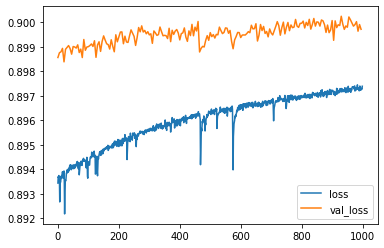

In [29]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [30]:
model.save("./model/cite_v36_cont")

INFO:tensorflow:Assets written to: ./model/cite_v36_cont/assets


In [31]:
epoc=2000
# train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epochs, verbose=1,validation_freq=5, callbacks=[model_checkpoint_callback])
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8973
Epoch 2/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8973
Epoch 3/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8973
Epoch 4/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8973
Epoch 5/2000
121/121 [==============================] - 33s 273ms/step - loss: -0.8974 - val_loss: -0.9002
Epoch 6/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8973
Epoch 7/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8973
Epoch 8/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8974
Epoch 9/2000
121/121 [==============================] - 32s 260ms/step - loss: -0.8972
Epoch 10/2000
121/121 [==============================] - 33s 273ms/step - loss: -0.8973 - val_loss: -0.8998
Epoch 11/2000
121/121 [==============================] - 32s 260ms/step - loss: -0.8974
E

121/121 [==============================] - 33s 272ms/step - loss: -0.8975 - val_loss: -0.8999
Epoch 91/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8975
Epoch 92/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8974
Epoch 93/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8974
Epoch 94/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8975
Epoch 95/2000
121/121 [==============================] - 33s 272ms/step - loss: -0.8974 - val_loss: -0.9000
Epoch 96/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8976
Epoch 97/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8975
Epoch 98/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8975
Epoch 99/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8974
Epoch 100/2000
121/121 [==============================] - 33s 272ms/step - loss: -0.8975 - val

121/121 [==============================] - 31s 259ms/step - loss: -0.8977
Epoch 179/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8975
Epoch 180/2000
121/121 [==============================] - 33s 272ms/step - loss: -0.8976 - val_loss: -0.8998
Epoch 181/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8976
Epoch 182/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8977
Epoch 183/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8976
Epoch 184/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8976
Epoch 185/2000
121/121 [==============================] - 33s 272ms/step - loss: -0.8976 - val_loss: -0.8997
Epoch 186/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8976
Epoch 187/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8976
Epoch 188/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

121/121 [==============================] - 31s 259ms/step - loss: -0.8978
Epoch 267/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8978
Epoch 268/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8978
Epoch 269/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8977
Epoch 270/2000
121/121 [==============================] - 33s 272ms/step - loss: -0.8978 - val_loss: -0.9001
Epoch 271/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8978
Epoch 272/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8977
Epoch 273/2000
121/121 [==============================] - 31s 260ms/step - loss: -0.8978
Epoch 274/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8977
Epoch 275/2000
121/121 [==============================] - 33s 272ms/step - loss: -0.8977 - val_loss: -0.9001
Epoch 276/2000
121/121 [==============================] - 31s 259ms/step - loss: -0.8

KeyboardInterrupt: 

In [32]:
model.save("./model/cite_v36_cont")

INFO:tensorflow:Assets written to: ./model/cite_v36_cont/assets


In [33]:
# del model
gc.collect()
K.clear_session()


ValueError: x and y must have same first dimension, but have shapes (2000,) and (1000,)

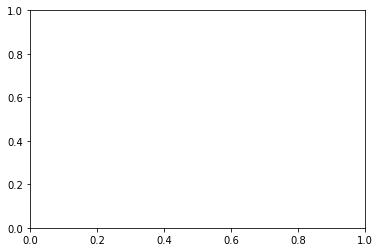

In [34]:
plt.plot(list(range(epoc)),np.array(train_hist.history['loss'])*(-1),label='loss')
plt.plot(list(range(0,epoc,5)),np.array(train_hist.history['val_loss'])*(-1),label='val_loss')
plt.legend(['loss', 'val_loss'])

In [35]:
train_hist.history

{'loss': [-0.8934421539306641,
  -0.8937042951583862,
  -0.8936650156974792,
  -0.893750011920929,
  -0.8936623334884644,
  -0.8935425877571106,
  -0.8926741480827332,
  -0.8933147192001343,
  -0.8934929370880127,
  -0.8934866189956665,
  -0.8937186598777771,
  -0.8936547636985779,
  -0.893629252910614,
  -0.8937796354293823,
  -0.8937992453575134,
  -0.893904447555542,
  -0.8937687277793884,
  -0.8938350677490234,
  -0.8936397433280945,
  -0.8939175605773926,
  -0.8939343094825745,
  -0.893463134765625,
  -0.8921849727630615,
  -0.893109142780304,
  -0.8935063481330872,
  -0.8935499787330627,
  -0.8935387134552002,
  -0.8937300443649292,
  -0.8938557505607605,
  -0.8938388824462891,
  -0.8939791321754456,
  -0.8938802480697632,
  -0.8938807845115662,
  -0.893994152545929,
  -0.8938941359519958,
  -0.894037127494812,
  -0.8939347863197327,
  -0.8940699696540833,
  -0.8940867781639099,
  -0.8941748738288879,
  -0.8940764665603638,
  -0.8941085934638977,
  -0.8941901326179504,
  -0.89399

In [36]:
cite_train_x_gen = MultiomeSequence_test(cite_train_x_raw, batch_size=4)
train_pred_y = model.predict(cite_train_x_gen)

In [37]:
train_pred_y.shape

(70988, 140)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0fd8eced30>]],
      dtype=object)

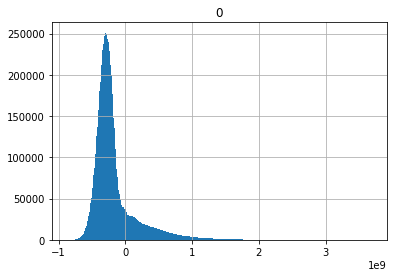

In [38]:
pd.DataFrame(train_pred_y.reshape(-1)).hist(bins=500)

(-5, 20)

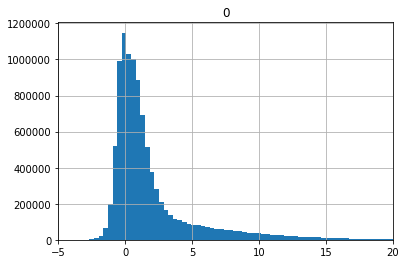

In [39]:
pd.DataFrame(cite_train_y_raw.reshape(-1)).hist(bins=500)
plt.xlim(-5,20)

In [40]:
cite_train_y_raw.shape

(70988, 140)

In [41]:
CorrelationLoss_new()(train_pred_y, cite_train_y_raw)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.90476525>

In [42]:
cite_train_x_raw.shape

(70988, 22052)

In [ ]:
retraining_generator = MultiomeSequence(cite_train_x_raw, cite_train_y_raw, batch_size=b_size)

In [ ]:
%%time
# Cross-validation
# multi_train_x = multi_train_x_raw
# multi_train_y = multi_train_y_raw
gc.collect()
K.clear_session()
model = None
model = my_model_2(cite_train_x_raw.shape[1], cite_train_y_raw.shape[1], 4096, 4, init_dropout=0.2, layer_dropout=0.7, activation='selu')
print(model.summary())
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),loss = CorrelationLoss_new())

In [37]:
epoc = 6000
train_hist = model.fit(retraining_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

Epoch 1/1000
17/17 [==============================] - 15s 819ms/step - loss: -0.7471
Epoch 2/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.8016
Epoch 3/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8018
Epoch 4/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8032
Epoch 5/1000
17/17 [==============================] - 29s 2s/step - loss: -0.8033 - val_loss: -0.8060
Epoch 6/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.8028
Epoch 7/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.8023
Epoch 8/1000
17/17 [==============================] - 14s 820ms/step - loss: -0.8036
Epoch 9/1000
17/17 [==============================] - 14s 822ms/step - loss: -0.8035
Epoch 10/1000
17/17 [==============================] - 28s 2s/step - loss: -0.8034 - val_loss: -0.8056
Epoch 11/1000
17/17 [==============================] - 14s 822ms/step - loss: -0.8042
Epoch 12/1000
17/17 [========

17/17 [==============================] - 14s 821ms/step - loss: -0.9003
Epoch 183/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9007
Epoch 184/1000
17/17 [==============================] - 14s 820ms/step - loss: -0.9009
Epoch 185/1000
17/17 [==============================] - 28s 2s/step - loss: -0.9021 - val_loss: -0.9085
Epoch 186/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9016
Epoch 187/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9015
Epoch 188/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9008
Epoch 189/1000
17/17 [==============================] - 14s 819ms/step - loss: -0.9011
Epoch 190/1000
17/17 [==============================] - 28s 2s/step - loss: -0.9020 - val_loss: -0.9091
Epoch 191/1000
17/17 [==============================] - 14s 823ms/step - loss: -0.9025
Epoch 192/1000
17/17 [==============================] - 14s 821ms/step - loss: -0.9026
Epoch 193/1000
17/17 [==

KeyboardInterrupt: 

In [ ]:
epoc = 1000
train_hist = model.fit(training_generator, validation_data=validation_generator, batch_size=b_size,epochs=epoc, verbose=1,validation_freq=5)

# Predicting

In [43]:
cite_test_df = pd.read_hdf(FP_CITE_TEST_INPUTS)
cite_test_df = cite_test_df.merge(cell_df, how='left',left_on='cell_id', right_on='cell_id').set_index('cell_id')
cite_test_x = cite_test_df.values
cite_test_x.shape

(48663, 22052)

In [44]:
cite_test_x_gen = MultiomeSequence_test(cite_test_x, batch_size=9)

In [45]:
test_pred = model.predict(cite_test_x_gen)

In [46]:
test_pred=test_pred/2000

In [47]:
test_pred.shape

(48663, 140)

In [48]:
test_pred

array([[-165445.44 , -167558.53 , -148743.83 , ..., -161008.75 ,
         -69113.7  ,  -71494.2  ],
       [-172564.27 , -172205.56 , -153316.45 , ..., -167824.64 ,
         -55662.523,  -74159.66 ],
       [-102770.69 ,  -89582.11 ,  -75638.53 , ...,  -97338.516,
         131517.22 ,  -11503.199],
       ...,
       [-101230.28 ,  -71525.51 ,  -79493.13 , ...,  -96344.93 ,
         -75251.055,  -34143.984],
       [-131902.03 , -117050.52 ,  -90718.34 , ..., -120680.05 ,
         153475.9  ,   40188.527],
       [-143716.   , -119858.38 ,  -93608.04 , ..., -130258.13 ,
         208732.47 ,   48772.234]], dtype=float32)

In [49]:
gc.collect()

36294

In [50]:
submission_prev = pd.read_csv('submission 804 NN.csv')['target']

In [51]:
submission_prev

0           9.460453e-02
1          -1.623624e-01
2          -4.053319e-01
3          -3.025821e-01
4           1.114355e+00
                ...     
65744175    9.840503e+09
65744176    0.000000e+00
65744177    0.000000e+00
65744178    1.860109e+09
65744179    9.638013e+09
Name: target, Length: 65744180, dtype: float64

In [52]:
test_pred.ravel().shape

(6812820,)

In [53]:
submission_prev.iloc[:len(test_pred.ravel())] = test_pred.ravel()

In [54]:
submission_prev = pd.DataFrame(submission_prev)

In [55]:
submission_prev.index.name="row_id"

In [56]:
submission_prev

,target
row_id,
0,-1.654454e+05
1,-1.675585e+05
2,-1.487438e+05
3,7.499988e+04
4,1.279194e+05
...,...
65744175,9.840503e+09
65744176,0.000000e+00
65744177,0.000000e+00


In [57]:
submission_prev.to_csv("submission.csv")